<a href="https://colab.research.google.com/github/PersonalRec/Python-DS-and-ML/blob/main/CIFAR-10_image_classification_using_a_custom_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification using a custom NN based on a modified LeNet-5 architecture on the CIFAR-10 dataset

The classic LeNet-5 architecture (proposed by Yann LeCun in 1998), based on a single 5x5 convolutional layer, Tanh activation function, and AvgPooling, achieves a little over 50% accuracy on the CIFAR-10 dataset. However, a modified architecture (called here "cifar_aug") using two 3x3 convolutional layers, ReLU activation function, MaxPooling, batch normalization, and dropout, combined with image augmentation, significantly boosts accuracy to over 80%. Additionally, these techniques greatly reduce overfitting, enabling further learning with more epochs.

In this project, I study how changes in various parameters affect neural network performance. This demonstrates that even an old architecture like LeNet-5, when updated with modern techniques and tweaks, can yield decent results.

### Import the necessary libraries

In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, ColorJitter, RandomRotation

### Setup the seed value

In [2]:
def set_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set your seed value
SEED = 42  # You can choose any integer
set_seed(SEED)

### Load the CIFAR dataset

In [3]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


### Set the Train and Test parts of the dataset

In [4]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

### Train and test parts

In [5]:
len(y_train), len(y_test)

(50000, 10000)

### The pictures are encoded with values from 0 to 255. We will use normalization afterfwards.

In [6]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

### Data normalization (from 0 : 255 to 0 : 1).

In [7]:
X_train /= 255.
X_test /= 255.

### Let's look at the available target classes in the CIFAR-10 dataset.

In [8]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Show some image examples.

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

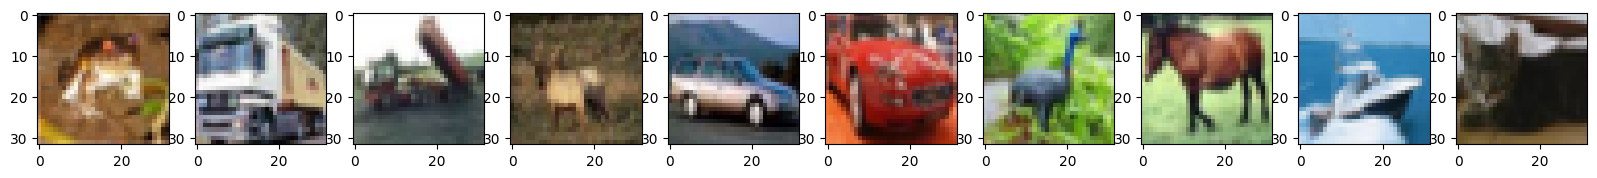

In [9]:
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [10]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

### Rearrange the dimensions of the tensors (put the channels number on the second position)

In [11]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [12]:
X_train.shape

torch.Size([50000, 3, 32, 32])

### Modified LeNet-5 NN

The modified LeNet 5 will have several options for testing:
1. TanH and ReLU activation functions.
2. One 5x5 convolutional layer or two 3x3 layers.
3. AvgPooling and MaxPooling.
4. Effect of the Batch Normalization.
5. Effect of dropout and its rates.


In [13]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5,
                 use_batch_norm=False,
                 use_dropout=False,
                 dropout_rate=0.5,
                 ):
        super(LeNet5, self).__init__()

        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function = torch.nn.ReLU()
        else:
            raise NotImplementedError

        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError

        if conv_size == 5:
          self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0)
          self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
          self.conv1_1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=0)
          self.conv1_2 = torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=0)
          self.conv2_1 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0)
          self.conv2_2 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
          raise NotImplementedError

        if use_dropout:
            self.drop = torch.nn.Dropout(p=dropout_rate)

        # Assign the 1st activation function, batch_normalization and pooling

        self.act1 = activation_function
        self.bn = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer

        # Assign the 2nd activation function, batch_normalization and pooling

        self.act2 = activation_function
        self.pool2 = pooling_layer

        # After the previous operations the images will be 5x5 with 16 channels (feature maps)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.act3 = activation_function

        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function

        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):

      # First convolutional block
      # If conv_size = 5, we will use one convolution layer 5x5
      if self.conv_size == 5:
        x = self.conv1(x)

      # Otherwise, we will use two convolution layers 3x3
      elif self.conv_size == 3:
        x = self.conv1_2(self.conv1_1(x))

      # Use batch normalization if use_batch_norm=True
      if self.use_batch_norm:
        x = self.bn(x)

      # 1st linear activation layer
      x = self.act1(x)

      # 1st pooling layer
      x = self.pool1(x)


      # Second convolutional block
      # If conv_size = 5, we will use one convolution layer 5x5
      if self.conv_size == 5:
        x = self.conv2(x)

      # Otherwise, we will use two convolution layers 3x3
      elif self.conv_size == 3:
        x = self.conv2_2(self.conv2_1(x))

      # 2nd linear activation layer
      x = self.act2(x)

      # 2nd pooling layer
      x = self.pool2(x)


      # Reshape a 4D tensor into a 2D tensor to be able to feed it into an FC layer
      x = x.view(x.size(0), -1)


      # Fully connected layers
      x = self.fc1(x)
      x = self.act3(x)
      if self.use_dropout:
        x = self.drop(x)

      x = self.fc2(x)
      x = self.act4(x)
      if self.use_dropout:
        x = self.drop(x)
      x = self.fc3(x)
      return x

### Define the training function

In [14]:
def train(net, X_train, y_train, X_test, y_test, b_size=1000, weight_decay=False, decay=1e-3, augmentation=False, epochs=60):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()

    if weight_decay:
        optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=decay)
    else:
        optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    batch_size = b_size

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    if augmentation:
      # Create the augmentation transform
      train_transform = get_advanced_train_transform()

    # We will run the NN for some epochs
    for epoch in range(epochs):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()

            # Set the NN to the learning mode
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            if augmentation:
              # Apply augmentation to the batch
              X_batch = train_transform(X_batch)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        # Set the NN to the prediction mode
        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        if epoch == 0 or epoch % 5 == 0 or epoch == epochs - 1:
            print(f'Epoch: {epoch}, Accuracy: {round(accuracy.item(), 3)}')

    del net
    return test_accuracy_history, test_loss_history

# Define the results dictionaries
accuracies = {}
losses = {}

### Test different variants of the LeNet-5 NN

In [15]:
print("\nTest the NN with the TanH loss, 1 convolutional layer 5x5, AvgPooling, no batch normalization, no dropout.")
accuracies['tanh'], losses['tanh'] = train(LeNet5(activation='tanh', conv_size=5), X_train, y_train, X_test, y_test)

print("\nTest the NN with the ReLU loss, 1 convolutional layer 5x5, AvgPooling, no batch normalization, no dropout.")
accuracies['relu'], losses['relu'] = train(LeNet5(activation='relu', conv_size=5), X_train, y_train, X_test, y_test)

print('\nTest the NN with the ReLU loss, 2 convolutional layers 3x3, AvgPooling, no batch normalization, no dropout.')
accuracies['relu_3'], losses['relu_3'] = train(LeNet5(activation='relu', conv_size=3), X_train, y_train, X_test, y_test)

print('\nTest the NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, no batch normalization, no dropout.')
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = train(LeNet5(activation='relu', conv_size=3, pooling='max'), X_train, y_train, X_test, y_test)

print('\nTest the NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, no dropout.')
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), X_train, y_train, X_test, y_test)

print('\nTest the NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, plus dropout = 0.2.')
accuracies['relu_3_max_pool_bn_drop_02'], losses['relu_3_max_pool_bn_drop_02'] = train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True, use_dropout=True, dropout_rate=0.2), X_train, y_train, X_test, y_test)

print('\nTest the NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, plus dropout = 0.5.')
accuracies['relu_3_max_pool_bn_drop_05'], losses['relu_3_max_pool_bn_drop_05'] = train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True, use_dropout=True, dropout_rate=0.5), X_train, y_train, X_test, y_test)


Test the NN with the TanH loss, 1 convolutional layer 5x5, AvgPooling, no batch normalization, no dropout.
Epoch: 0, Accuracy: 0.303
Epoch: 5, Accuracy: 0.412
Epoch: 10, Accuracy: 0.471
Epoch: 15, Accuracy: 0.508
Epoch: 20, Accuracy: 0.523
Epoch: 25, Accuracy: 0.538
Epoch: 30, Accuracy: 0.551
Epoch: 35, Accuracy: 0.553
Epoch: 40, Accuracy: 0.562
Epoch: 45, Accuracy: 0.565
Epoch: 50, Accuracy: 0.567
Epoch: 55, Accuracy: 0.568
Epoch: 59, Accuracy: 0.569

Test the NN with the ReLU loss, 1 convolutional layer 5x5, AvgPooling, no batch normalization, no dropout.
Epoch: 0, Accuracy: 0.244
Epoch: 5, Accuracy: 0.398
Epoch: 10, Accuracy: 0.461
Epoch: 15, Accuracy: 0.487
Epoch: 20, Accuracy: 0.521
Epoch: 25, Accuracy: 0.528
Epoch: 30, Accuracy: 0.531
Epoch: 35, Accuracy: 0.535
Epoch: 40, Accuracy: 0.552
Epoch: 45, Accuracy: 0.562
Epoch: 50, Accuracy: 0.574
Epoch: 55, Accuracy: 0.58
Epoch: 59, Accuracy: 0.584

Test the NN with the ReLU loss, 2 convolutional layers 3x3, AvgPooling, no batch norma

### Plot the experiment results: Accuracy

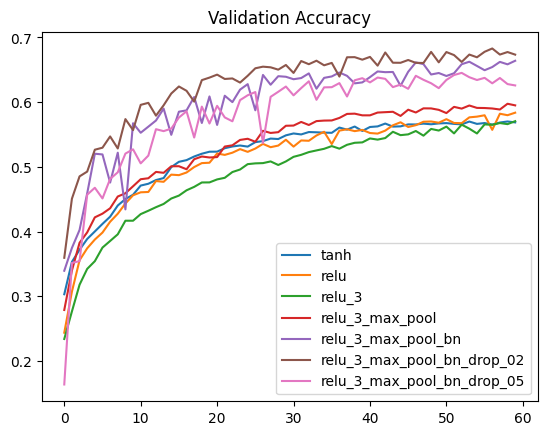

In [16]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

### Plot the experiment results: Loss



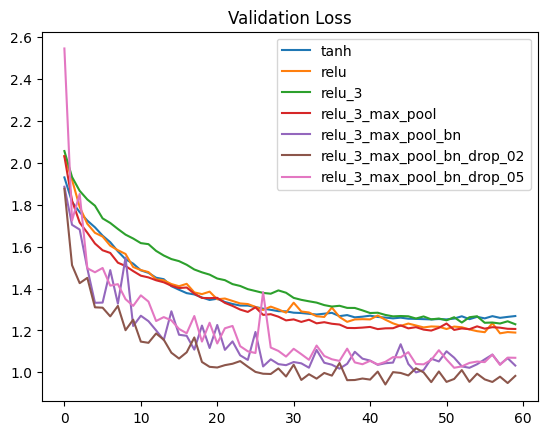

In [17]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

### Custom CIFAR-Net NN

We will take the best parameters from the previous NN.

In [18]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()

        self.drop = torch.nn.Dropout(p=0.5)
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        # Here we will use padding=1, so the conv layer will "see" the borders of the picture and will not modify the picture size
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.act = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.batch_norm2 = torch.nn.BatchNorm2d(32)

        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1 = torch.nn.Linear(64 * 8 * 8, 256)
        self.batch_norm4 = torch.nn.BatchNorm1d(256)

        self.fc2 = torch.nn.Linear(256, 64)
        self.batch_norm5 = torch.nn.BatchNorm1d(64)

        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = self.batch_norm0(x)

        x = self.conv1(x)
        x = self.act(x)
        x = self.batch_norm1(x)
        x = self.pool(x)


        x = self.conv2(x)
        x = self.act(x)
        x = self.batch_norm2(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.act(x)
        x = self.batch_norm3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)

        return x



### Test the custom CIFAR NN with and without the L2 regularization

In [19]:
print('\nTest the custom CIFAR NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, plus dropout = 0.5.')
accuracies['cifar'], losses['cifar'] = train(CIFARNet(), X_train, y_train, X_test, y_test)


Test the custom CIFAR NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, plus dropout = 0.5.
Epoch: 0, Accuracy: 0.547
Epoch: 5, Accuracy: 0.716
Epoch: 10, Accuracy: 0.721
Epoch: 15, Accuracy: 0.724
Epoch: 20, Accuracy: 0.721
Epoch: 25, Accuracy: 0.728
Epoch: 30, Accuracy: 0.728
Epoch: 35, Accuracy: 0.73
Epoch: 40, Accuracy: 0.73
Epoch: 45, Accuracy: 0.728
Epoch: 50, Accuracy: 0.727
Epoch: 55, Accuracy: 0.724
Epoch: 59, Accuracy: 0.733


In [20]:
print('\nTest the custom CIFAR NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, dropout = 0.5, L2 reg = 1e-3')
accuracies['cifar_l2_1e-3'], losses['cifar_l2_1e-3'] = train(CIFARNet(), X_train, y_train, X_test, y_test, weight_decay=True, decay=1e-3)


Test the custom CIFAR NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, dropout = 0.5, L2 reg = 1e-3
Epoch: 0, Accuracy: 0.551
Epoch: 5, Accuracy: 0.707
Epoch: 10, Accuracy: 0.717
Epoch: 15, Accuracy: 0.729
Epoch: 20, Accuracy: 0.729
Epoch: 25, Accuracy: 0.727
Epoch: 30, Accuracy: 0.728
Epoch: 35, Accuracy: 0.737
Epoch: 40, Accuracy: 0.733
Epoch: 45, Accuracy: 0.73
Epoch: 50, Accuracy: 0.732
Epoch: 55, Accuracy: 0.73
Epoch: 59, Accuracy: 0.731


In [21]:
print('\nTest the custom CIFAR NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, dropout = 0.5, L2 reg = 1e-4')
accuracies['cifar_l2_1e-4'], losses['cifar_l2_1e-4'] = train(CIFARNet(), X_train, y_train, X_test, y_test, weight_decay=True, decay=1e-4)


Test the custom CIFAR NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, dropout = 0.5, L2 reg = 1e-4
Epoch: 0, Accuracy: 0.543
Epoch: 5, Accuracy: 0.715
Epoch: 10, Accuracy: 0.736
Epoch: 15, Accuracy: 0.724
Epoch: 20, Accuracy: 0.728
Epoch: 25, Accuracy: 0.737
Epoch: 30, Accuracy: 0.731
Epoch: 35, Accuracy: 0.729
Epoch: 40, Accuracy: 0.74
Epoch: 45, Accuracy: 0.736
Epoch: 50, Accuracy: 0.734
Epoch: 55, Accuracy: 0.734
Epoch: 59, Accuracy: 0.731


In [22]:
#print('\nTest the custom CIFAR NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, dropout = 0.5, L2 reg = 1e-5')
accuracies['cifar_l2_1e-5'], losses['cifar_l2_1e-5'] = train(CIFARNet(), X_train, y_train, X_test, y_test, weight_decay=True, decay=1e-5)

Epoch: 0, Accuracy: 0.53
Epoch: 5, Accuracy: 0.713
Epoch: 10, Accuracy: 0.72
Epoch: 15, Accuracy: 0.72
Epoch: 20, Accuracy: 0.727
Epoch: 25, Accuracy: 0.722
Epoch: 30, Accuracy: 0.723
Epoch: 35, Accuracy: 0.725
Epoch: 40, Accuracy: 0.727
Epoch: 45, Accuracy: 0.725
Epoch: 50, Accuracy: 0.721
Epoch: 55, Accuracy: 0.725
Epoch: 59, Accuracy: 0.729


### Plot the experiment results: Accuracy

In [23]:
cifar_results = list(accuracies.keys())[-4:]

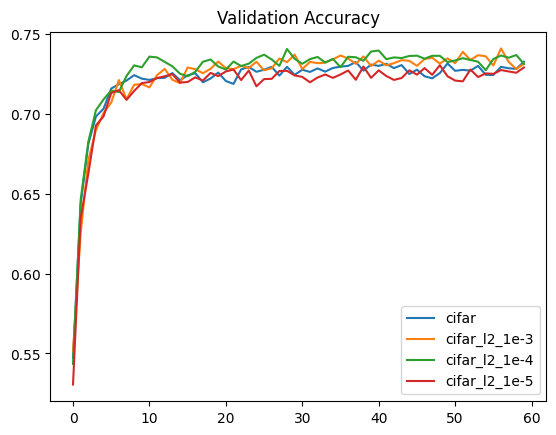

In [24]:
for experiment_id in cifar_results:
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

### Plot the experiment results: Loss

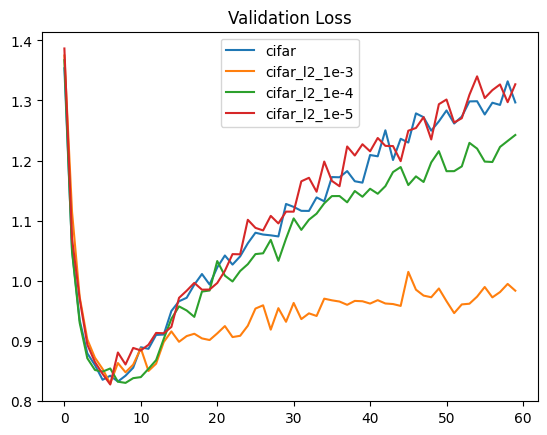

In [25]:
for experiment_id in cifar_results:
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

# Image augmentation

In [26]:
def get_advanced_train_transform():
    return transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(degrees=15),
        #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
        #transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        # Remove ToTensor() as data is already in tensor format
        #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

In [27]:
print('\nTest the custom CIFAR NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, dropout = 0.5, L2 reg = 1e-3, and image augmentation')
accuracies['cifar_aug'], losses['cifar_aug'] = train(CIFARNet(), X_train, y_train, X_test, y_test, weight_decay=True, decay=1e-3, augmentation=True)


Test the custom CIFAR NN with the ReLU loss, 2 convolutional layers 3x3, MaxPooling, plus batch normalization, dropout = 0.5, L2 reg = 1e-3, and image augmentation
Epoch: 0, Accuracy: 0.525
Epoch: 5, Accuracy: 0.711
Epoch: 10, Accuracy: 0.744
Epoch: 15, Accuracy: 0.763
Epoch: 20, Accuracy: 0.771
Epoch: 25, Accuracy: 0.783
Epoch: 30, Accuracy: 0.779
Epoch: 35, Accuracy: 0.79
Epoch: 40, Accuracy: 0.793
Epoch: 45, Accuracy: 0.793
Epoch: 50, Accuracy: 0.8
Epoch: 55, Accuracy: 0.802
Epoch: 59, Accuracy: 0.808


### Plot the experiment results: Accuracy

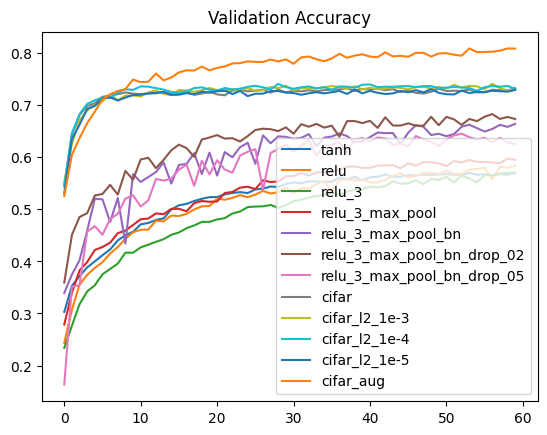

In [28]:
for experiment_id in accuracies:
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

### Plot the experiment results: Loss

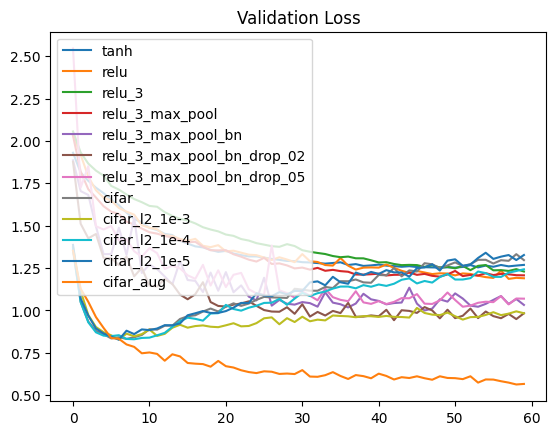

In [29]:
for experiment_id in accuracies:
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');